In [1]:
# Imports
import os
import numpy as np
import pandas as pd 
import csv
import matplotlib.pyplot as plt
from math import sqrt
import datetime

from sklearn import neighbors
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
#from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import confusion_matrix

from pymongo import MongoClient

In [2]:
# Fonction permettant d'obtenir un visuel rapide et clair des données
# params :
#    data_name : nom du fichier où se trouvent les données
# returns :
#    df : dataframe contenant les données
def load_data(data_name):
    _, ext = os.path.splitext(data_name)
    
    if ext == '.csv' : 
        with open(data_name, newline='') as csvfile:
            dialect = csv.Sniffer().sniff(csvfile.readline(), [',',';'])
            csvfile.close()
        df = pd.read_csv(data_name, dialect=dialect)
    
    if ext == '.json' :
        print('json')
        
    print(descript_df(df))
    return df 

In [3]:
# Fonction permettant de faire une description rapide du dataframe de sortie
# params :
#    dataframe : dataframe contenant les données
# returns :
#    display : description rapide des données
def descript_df(dataframe):
    
    print('Matrice de corrélation : \n')
    corr = dataframe.corr()
    corr_color = plt.matshow(corr, cmap=plt.cm.Reds)
    
    # Pour chaque colonne, montrer la répartition des valeurs (vérifier les valeurs aberrantes)
    # Kde et Histogramme
    i = 1
    for column in dataframe:
        i += 1
        plt.figure(i, figsize=(15,3))
        plt.subplot(121)
        dataframe[column].plot.kde()
        plt.title('Répartition de ' + column + ' : ')
        plt.subplot(122)
        dataframe[column].hist()
        plt.title('Histogramme de ' + column + ' : ')
    
    display = corr
    return display

In [4]:
# Fonction permettant de créer les bases d'apprentissage et de test
# params :
#    dataframe : dataframe contenant les données
#    column_target : string de la colonne-cible à estimer
#    test_size : ratio de la base de test (30% par défaut)
# returns :
#    base : tuple des bases d'apprentissage et de test
def split_base(dataframe, column_target, test_size = 0.3):
    
    # Gestion erreur test_size
    if(test_size <= 0 or test_size >= 1):
        return "Erreur sur le ratio de test_size : vérifier que test_size est compris entre 0 et 1. \n"
    
    # Gestion erreur column_target comme string
    elif (isinstance(column_target, str) == False):
        return "Erreur sur le type de column_target : vérifier que column_target est bien une string. \n"
    
    else:
        train, test = train_test_split(dataframe, test_size = test_size)

        X_train = train.drop(column_target, axis=1)
        y_train = train[column_target]

        X_test = test.drop(column_target, axis=1)
        y_test = test[column_target]
        
        base = X_train, y_train, X_test, y_test
        
        return base

In [5]:
# Fonction permettant d'appeler les bons indicateurs de performances et de récupérer les informations utiles
# params :
#    pipeline : sortie de la pipeline
#    bool_type_modele : booléen pour le type du modèle (0 : régression / 1 : classification)
#    base : tuple des bases d'apprentissage et de test
#    collection : collection de la base de données où stocker les données
# returns :
#    perfs : performances des différents indicateurs et graphiques
def perform_on_pipeline(pipeline, bool_type_modèle, base, collection):
    if (bool_type_modèle == 0) : 
        print("Choix du type d'estimateur : Régression \n")
        perfs = indic_perform_reg(pipeline, base)

    else:
        print("Choix du type d'estimateur : Classification \n")
        perfs = indic_perform_class(pipeline, base)
        
    # poster les scores dans la database
    collection.insert_one(perfs)
        
    return perfs
    

In [6]:
# Fonction permettant d'obtenir les résultats des indicateurs de performances d'une régression
# params :
#    pipeline : sortie de la pipeline
#    base : tuple des bases d'apprentissage et de test
# returns :
#    rmse : score RMSE
#    r2 : score R²
#    cross_val : score de cross-validation
def indic_perform_reg(pipeline, base):
    ''' # Fonction permettant d'obtenir les résultats des indicateurs de performances d'une régression
        # params :
        #    pipeline : sortie de la pipeline
        #    base : tuple des bases d'apprentissage et de test
    '''
    # Pré-process ?
    pipeline_fit = pipeline.fit(base[0],base[1]) # besoin du fit ou seulement du préd ? 
    pred = pipeline_fit.predict(base[2]) # besoin du predict ou déjà fait ? 
    
    # Calcul du RMSE
    rmse = sqrt(mean_squared_error(base[3], pred))
    
    # Calcul du R²
    r2 = r2_score(base[3], pred)
    
    # Cross-Validation
    cross_val = np.mean(cross_val_score(pipeline, base[2], base[3], cv=5))
    
    dico_perform = {'RMSE' : rmse, 'R2' : r2, 'Cross_val' : cross_val, 'Time' : datetime.datetime.now()}
    
    return dico_perform

In [7]:
# Fonction permettant d'obtenir les résultats des indicateurs de performances d'une classification
# params :
#    pipeline : sortie de la pipeline
#    X_test : variables de test pour évaluer les performances du modèle
#    y_test : valeurs de test pour évaluer les performances du modèle
# returns :
#    matrice_confu : matrice de confusion
#    classif_report : classification report
def indic_perform_class(pipeline, X_test, y_test):
    # Pré-process ?
    pipeline_fit = pipeline.fit(X_train,y_train) # besoin du fit ou seulement du préd ? 
    pred = pipeline_fit.predict(X_test) # besoin du predict ou déjà fait ? 
    
    # Calcul Matrice de confusion
    matrice_confu = False
    
    # Calcul du Classification Report
    classif_report = False
    
    return matrice_confu, classif_report

In [8]:
##############################  TEST  ##############################

C:\Users\elias\AppData\Local\Programs\Python\Python37-32\lib\site-packages\pandas\io\parsers.py:440: ParserWarning: Conflicting values for 'doublequote': 'True' was provided, but the dialect specifies 'False'. Using the dialect-specified value.
  parser = TextFileReader(filepath_or_buffer, **kwds)


Matrice de corrélation : 

                       Gender  Age Range  Head Size(cm^3)  Brain Weight(grams)
Gender               1.000000  -0.088652        -0.514050            -0.465266
Age Range           -0.088652   1.000000        -0.105428            -0.169438
Head Size(cm^3)     -0.514050  -0.105428         1.000000             0.799570
Brain Weight(grams) -0.465266  -0.169438         0.799570             1.000000


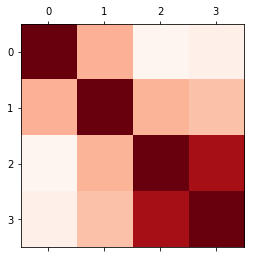

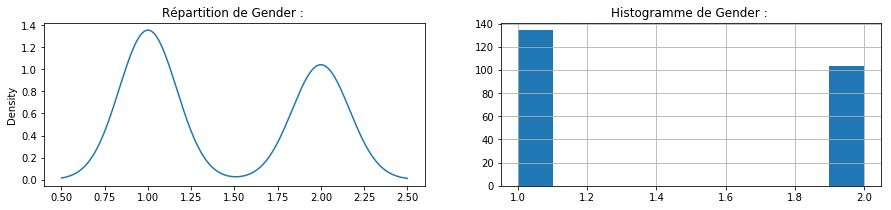

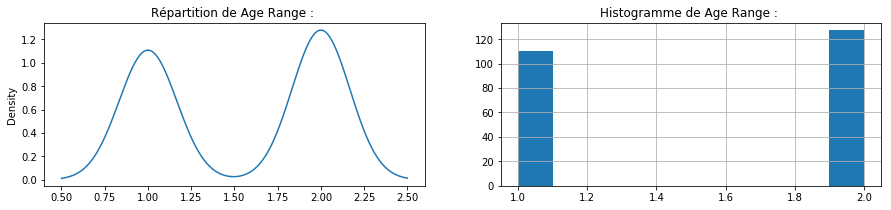

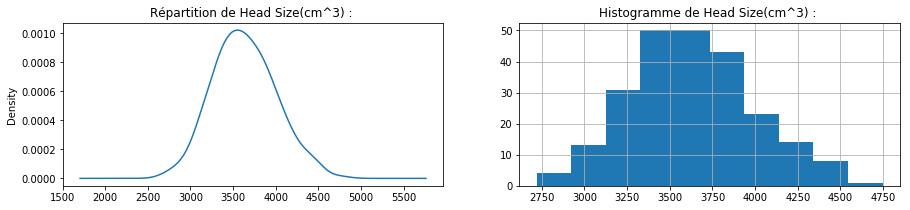

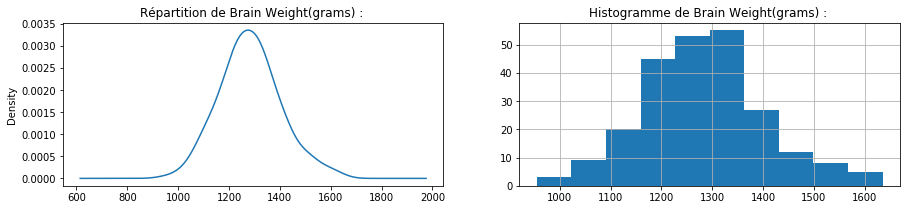

In [9]:
# Loading du dataframe et description
df_test = load_data("./../data/headbrain.csv")

In [10]:
# Création du client Mongo pour se connecter à la base de données

client = MongoClient('mongodb://localhost:27017/')

db = client.database_pipeline
collec = db.collection_pipeline_1  # Nom de la pipeline à remplir


In [11]:
# Nettoyage en amont / Choix des colonnes à utiliser ???

# Splitting entre apprentissage et test
base = split_base(df_test, "Brain Weight(grams)")

# Pipeline à utiliser
pipe_test = Pipeline([
    ('features', StandardScaler()),
    ('estimator', neighbors.KNeighborsRegressor())   
])

# Calculer les performances selon le type d'estimateur
perform = perform_on_pipeline(pipe_test, 0, base, collec)
perform # why _id ?

Choix du type d'estimateur : Régression 



C:\Users\elias\AppData\Local\Programs\Python\Python37-32\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\elias\AppData\Local\Programs\Python\Python37-32\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\elias\AppData\Local\Programs\Python\Python37-32\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\elias\AppData\Local\Programs\Python\Python37-32\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\elias\AppData\Local\Programs\

{'RMSE': 87.9746143940272,
 'R2': 0.577582851634225,
 'Cross_val': 0.46582922912320857,
 'Time': datetime.datetime(2019, 3, 12, 16, 25, 15, 891800),
 '_id': ObjectId('5c87cf5b6e868632e0150a2b')}

In [12]:
def mycfm(y_true, y_pred):  
    """
    Rend une jolie matrice de confusion (cas binaire) et les principaux scores associés
    
    Arguments :
    -----------
    y_true: array
         les vraies classes
    y_pred: array
         les classes prédites 
    """
    CC = pd.crosstab(y_true, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)
    """try:
        display_html(CC)
    except:
        print(CC)
    """    
    print(CC)    
    C = np.array(CC)
    score = np.sum(np.diag(C)) / len(y_true) - 1
    precision = np.diag(C) / C[:,-1]
    print()
    print('{s:{c}<{n}}{num:2.3}'.format(s='Score', n=15, c='', num=score))

In [28]:
#from utils import bdd
from bson import Code

In [208]:
from pymongo import MongoClient
#'database_pipeline'

class MongoDB():
    def __init__(self,dbname):
        self.client = MongoClient()
        self.db = self.client[dbname]

    def get_collection_name(self):
        #Return all collection names
        return self.db.list_collection_names()
    
    def find(self, collection, _id=False, last=False):
        #retourne une list de dictionaire last=False
        #retoura cursor of documents of a specific collection, by default the function
        #doesn't select the _id field
        if _id == False:
            cursor = self.db[collection].find({}, {'_id': False})
        else:
            cursor = self.db[collection].find()
        
        if last == True:
            cursor = cursor.sort([("Time", -1)]).limit(1)
            return cursor[0]
        
        return self.cursor_to_dict(cursor)
    
    def find_all(self, _id=False, last=False):
        d = dict()
        for coll in self.get_collection_name():
            d[coll] = self.find(coll, _id, last)
        return d
            
    def cursor_to_dict(self, cursor):
        l = list()
        for i in cursor:
            l.append(i)
        return l
    
    def get_keys(self, collection):
        #Return all field name of a collection
        map = Code("function() { for (var key in this) { emit(key, null); } }")
        reduce = Code("function(key, stuff) { return null; }")
        result = self.db[collection].map_reduce(map, reduce, "myresults")
        return result.distinct('_id')

#docs = list(self.db[collec_pipe_name].find().sort([('Time', -1)]))


In [213]:
db = MongoDB("database_pipeline")
cursor = db.find("collection_pipeline_1")

In [214]:
cursor

[{'RMSE': 87.9746143940272,
  'R2': 0.577582851634225,
  'Cross_val': 0.46582922912320857,
  'Time': datetime.datetime(2019, 3, 12, 16, 25, 15, 891000)}]

In [182]:
db.cursor_to_dict(cursor)

TypeError: descriptor 'append' requires a 'list' object but received a 'dict'

In [170]:
dict(a)

ValueError: dictionary update sequence element #0 has length 4; 2 is required